# Gender Classification Based on Speech.

In [3]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import random
import os
import sys
from pathlib import Path
from helpers import *
import warnings
warnings.filterwarnings(action='once')

import soundfile as sf 
import python_speech_features as feat 

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from time import time
from keras.callbacks import History, ReduceLROnPlateau, TensorBoard, ModelCheckpoint, EarlyStopping

import seaborn as sn
import pandas as pd

# 1) Creating the Dataset.

### Reading the readers.TXT file and parsing it. Male label being 0 and female label being 1.

In [5]:
with open('../Downloads/LibriSpeech/SPEAKERS.TXT') as f:
    raw_lines = f.readlines() 
    
IDs = np.array([], dtype=int)
G = np.array([], dtype=int)


for line in raw_lines:
    if 'dev-clean' in line:
        IDs = np.append(IDs, int(line.split('|')[0]))
        
        if 'M' in line.split('|')[1]:
            G = np.append(G,0)
        elif 'F' in line.split('|')[1]:
            G = np.append(G,1)
            
IDs = np.expand_dims(IDs, axis=1)
G = np.expand_dims(G,axis=1)
            
readers_data = np.concatenate([IDs,G],axis=1)

print(readers_data.shape),type(readers_data)

(40, 2)


(None, numpy.ndarray)

### Split the readers between Male and Female.

In [6]:
M_readers = readers_data[readers_data[:,1]==0]
F_readers = readers_data[readers_data[:,1]==1]
M_readers.shape, F_readers.shape
#Perctly balanced dataset.
split_ratio = 0.80

train_IDs, test_IDs = train_test(M_readers,split_ratio)
M_train, M_test = M_readers[train_IDs], M_readers[test_IDs]

train_IDs, test_IDs = train_test(F_readers,split_ratio)
F_train, F_test = F_readers[train_IDs], F_readers[test_IDs]
M_train.shape,F_train.shape

train_readers, test_readers = np.concatenate([M_train,F_train],axis=0), np.concatenate([M_test,F_test],axis=0)
train_readers.shape , test_readers.shape

((20, 2), (20, 2))

### Regroupe all readers toghether to perform the split on the features rather than on readers.

In [9]:
all_readers =  np.concatenate([train_readers,test_readers],axis=0)
all_readers.shape

(40, 2)

### Features extraction: Create the dataset from the .flac files associated with all_readers.

We use MFCCs as our features for this classification tasks. We used python_speech_features library and kept almost all paramerters to default setting for the features extraction. The only parameter that made a significant impact on the performance of the models was numcep (the number of cepstrums) and 50 is the one that works the best from the few i tried. Atfer getting a feature vector for each frame, we average the values of the features from the same .flac file using a simple mean. One could use more complex averaging methods but in this case a simple mean acheived pretty nice results.

In [10]:
%%time
all_data, all_G = dataset_from_readers(all_readers)

print(all_data.shape)
print(all_G.shape)

(2703, 50)
(2703, 1)
CPU times: user 2min 36s, sys: 5min 2s, total: 7min 38s
Wall time: 57.6 s


### Train/Test Split on the audio files. (features,label) pairs

In [30]:
train_IDs, test_IDs = train_test(all_G,split_ratio)
train_data , train_G, test_data, test_G = all_data[train_IDs], all_G[train_IDs], all_data[test_IDs], all_G[test_IDs]
train_data.shape, train_G.shape

((2162, 50), (2162, 1))

### Normalize the data before feeding it to the Models.

In [31]:
train_data, test_data = normalize_data(train_data),normalize_data(test_data)
train_data.shape, test_data.shape,type(test_G[0][0])

((2162, 50), (541, 50), numpy.float64)

# 2) Modelization.

In [32]:
#Reshaping the data to the format expected by sklearn models.
train_G , test_G = train_G.reshape(train_G.shape[0],),test_G.reshape(test_G.shape[0],)

### Baseline: Dummy model (Always outputs Male).

In [33]:
#Prediction of the dummy model
y_pred = np.zeros(shape=test_G.shape, dtype=float)
acc = accuracy_score(test_G, y_pred)

#Results on the testset.
print("Test Accuracy : ", acc)

Test Accuracy :  0.47689463955637706


This tells us that our .flac dataset is a little bit imbalanced, we could use weights to even it out but we will see with the following that for this specific classification problem it won't be neccessary. This also set the base to arbitrary classification and gives us a first target to beat.

### Naive Bayes Classifier.

Training Accuracy :  0.9250693802035153
Test Accuracy :  0.9260628465804066
 
                       Classification report.

              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       258
         1.0       0.92      0.94      0.93       283

   micro avg       0.93      0.93      0.93       541
   macro avg       0.93      0.93      0.93       541
weighted avg       0.93      0.93      0.93       541



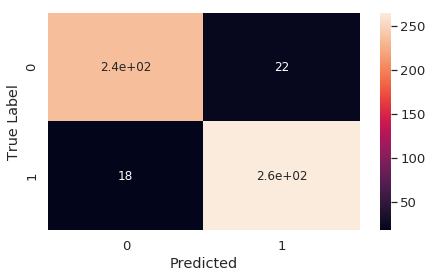

In [34]:
#Create the model.
model = GaussianNB()

#Train the model.
model.fit(train_data,train_G)

#Results on the testset.
train_accuracy = model.score(train_data,train_G)
print("Training Accuracy : ", train_accuracy)
test_accuracy = model.score(test_data,test_G)
print("Test Accuracy : ", test_accuracy)

visu_results(model,test_data,test_G)

### Logistic Regression Classifier.

Training Accuracy :  0.9791859389454209
Test Accuracy :  0.966728280961183
 
                       Classification report.

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       258
         1.0       0.97      0.96      0.97       283

   micro avg       0.97      0.97      0.97       541
   macro avg       0.97      0.97      0.97       541
weighted avg       0.97      0.97      0.97       541



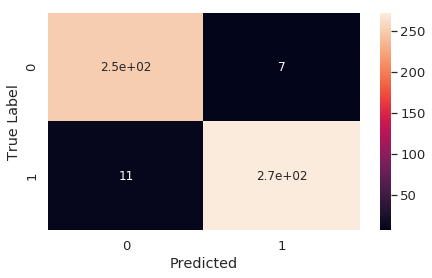

In [35]:
#Create the model
model = LogisticRegression(random_state=0,solver='lbfgs')

#Train the model.
model.fit(train_data,train_G)

#Results on the test set.
train_accuracy = model.score(train_data,train_G)
print("Training Accuracy : ", train_accuracy)
test_accuracy = model.score(test_data,test_G)
print("Test Accuracy : ", test_accuracy)

visu_results(model,test_data,test_G)

### Classic Feed Forward Neural Network (MLP).

In [36]:
#Create the model.
model = MLPClassifier(random_state=0, max_iter=200)


# Space on which the GS is performed.
parameter_space = {
    'hidden_layer_sizes': [(5,5), (10,5)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.1, 0.05],
    'learning_rate': ['constant','adaptive'],
}

#Create the GS.
model = GridSearchCV(model, parameter_space, n_jobs=-1, cv=3)

#Train the model.
model.fit(train_data, train_G)

# Best parameters set
print('Best parameters found:\n', model.best_params_)

# All results
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (10, 5), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.980 (+/-0.012) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (5, 5), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.979 (+/-0.016) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (5, 5), 'learning_rate': 'constant', 'solver': 'adam'}
0.980 (+/-0.012) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (5, 5), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
0.979 (+/-0.016) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (5, 5), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.987 (+/-0.010) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (10, 5), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.978 (+/-0.014) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (10, 5), 'learning_rate': 'constant', 'solver': 'adam'}
0.987 (+/-0.010) for {'activation': 'tanh', '

Training Accuracy :  1.0
Test Accuracy :  0.9852125693160814
 
                       Classification report.

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       258
         1.0       1.00      0.98      0.99       283

   micro avg       0.99      0.99      0.99       541
   macro avg       0.98      0.99      0.99       541
weighted avg       0.99      0.99      0.99       541



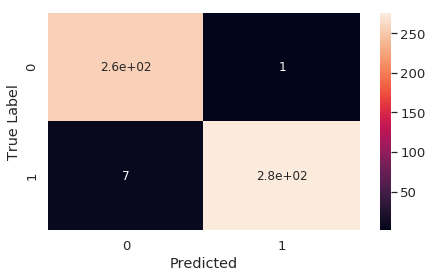

In [37]:
#Results on the test set.
train_accuracy = model.score(train_data,train_G)
print("Training Accuracy : ", train_accuracy)
test_accuracy = model.score(test_data,test_G)
print("Test Accuracy : ", test_accuracy)

visu_results(model,test_data,test_G)        

## Convolutional Neural Network. Implemented using Keras.

#### Sanity check: Prepare the data to feed it to the keras model.

In [38]:
train_G.shape, test_G.shape

((2162,), (541,))

In [39]:
#Add a dimention to the training_data so that it matches the expected format of the model.
train_data, test_data = np.expand_dims(train_data,axis=2), np.expand_dims(test_data,axis=2) 
train_data.shape, test_data.shape 

((2162, 50, 1), (541, 50, 1))

In [40]:
#Turn the labels (0,1) into hot-one-encoded vectors.
train_G , test_G = get_one_hot(train_G.astype(int),2),get_one_hot(test_G.astype(int),2)
train_G.shape, test_G.shape

((2162, 2), (541, 2))

#### Creating our CNN.

In [41]:
%%time

small_dataSize = 50
small_mse_history = History()
lr = 0.001

#Init the model.
small_model = initialize_model("softmax", small_dataSize,dropout_fraction)
#Compile the model.
compile_model(small_model, lr, "categorical_crossentropy",metrics=["accuracy"])

CPU times: user 341 ms, sys: 1.21 ms, total: 342 ms
Wall time: 341 ms


In [42]:
#Description of model layer by layer.
small_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 46, 10)            60        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 46, 10)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 45, 10)            210       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 45, 10)            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 45, 10)            40        
_________________________________________________________________
flatten_2 (Flatten)          (None, 450)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               45100     
__________

#### Creating our callbacks that will monitor the training.

In [43]:
earlyStopping = EarlyStopping(monitor='val_acc', patience=20, verbose=1, mode='auto', min_delta=0.0001,restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10, min_lr=1e-6,verbose=1, min_delta=1e-3)

#### Training the model.

In [44]:
history = small_model.fit(train_data[:2000], train_G[:2000], batch_size=100, epochs=200, verbose=1, callbacks=[small_mse_history,earlyStopping,reduce_lr_loss 
                ],validation_data=(test_data[:100], test_G[:100]),shuffle=True)

Train on 2000 samples, validate on 100 samples
Epoch 1/200
2000/2000 [==============================] - 2s 1ms/step - loss: 1.8961 - acc: 0.7210 - val_loss: 1.4003 - val_acc: 0.9300
Epoch 2/200
2000/2000 [==============================] - 0s 106us/step - loss: 1.4106 - acc: 0.8950 - val_loss: 1.2882 - val_acc: 0.9500
Epoch 3/200
2000/2000 [==============================] - 0s 115us/step - loss: 1.2856 - acc: 0.9275 - val_loss: 1.2145 - val_acc: 0.9500
Epoch 4/200
2000/2000 [==============================] - 0s 128us/step - loss: 1.1730 - acc: 0.9520 - val_loss: 1.1270 - val_acc: 0.9500
Epoch 5/200
2000/2000 [==============================] - 0s 123us/step - loss: 1.0878 - acc: 0.9595 - val_loss: 1.0537 - val_acc: 0.9500
Epoch 6/200
2000/2000 [==============================] - 0s 110us/step - loss: 1.0082 - acc: 0.9665 - val_loss: 0.9832 - val_acc: 0.9500
Epoch 7/200
2000/2000 [==============================] - 0s 100us/step - loss: 0.9385 - acc: 0.9770 - val_loss: 0.9049 - val_acc: 0.9

#### Evolution of the training vs validation Loss and Accuracy over the Epochs.

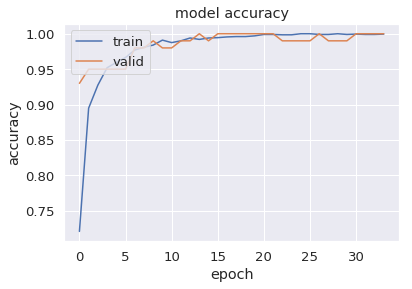

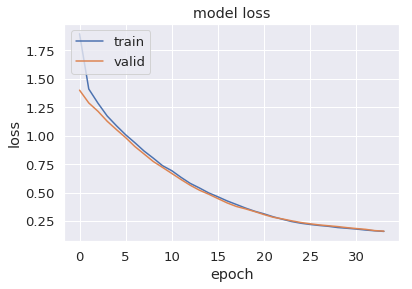

In [45]:
# summarize history for accuracy
plt.plot(small_mse_history.history['acc'])
plt.plot(small_mse_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(small_mse_history.history['loss'])
plt.plot(small_mse_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#### Visualisation of the results for the CNN.

In [46]:
#Score on the test set.
pred_score = small_model.evaluate(test_data[100:], test_G[100:], batch_size=100, verbose=1)
print("Test loss : ",pred_score[0],"; Overall test accuracy : ",pred_score[1])

441/441 [==============================] - 0s 52us/step
Test loss :  0.5083362137108973 ; Overall test accuracy :  1.0


In [47]:
# Convert one-hot to index and do the prediction on the test set.
Y_test = np.argmax(test_G[100:], axis=1) 
y_pred = small_model.predict(test_data[100:],verbose=1)
y_class = np.argmax(y_pred,axis=1)

441/441 [==============================] - 0s 322us/step


                     Classification Report 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       225

   micro avg       1.00      1.00      1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441
 

                                      Normalized Confusion Matrix 


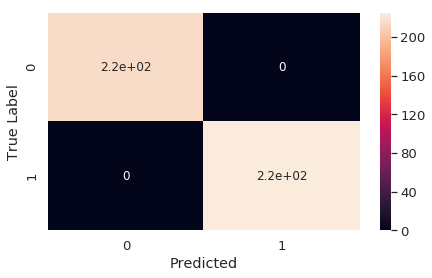

In [48]:
#Confution Matrix and Classification Report

cfm = confusion_matrix(Y_test, y_class)
cfm = cfm.astype('int') #/ cfm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cfm, range(2),range(2))
plt.figure(figsize = (7,4))
plt.xlabel('Predicted') 
plt.ylabel('True Label')
sn.set(font_scale=1.2)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.xlabel('Predicted') 
plt.ylabel('True Label')
print('                     Classification Report \n')
print(classification_report(Y_test, y_class ),'\n')
print('                                      Normalized Confusion Matrix ')

#### Calculate and plot the distributions of softmax activations for Good vs Bad classifications.

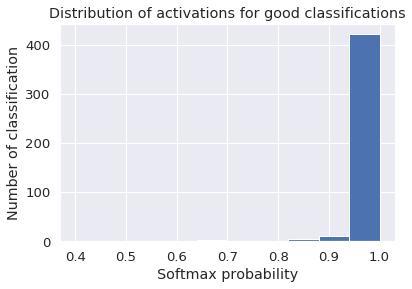

'\nbad_id = np.argwhere(Y_test != y_class)\nY_err = Y_test[bad_id].reshape(4,)\ny_bad = y_pred[bad_id]\ny_bad = np.max(y_bad,axis=2)\ny_bad.reshape(4,).shape\n\nplt.hist(y_bad, range =(0.40, 1.0), bins=10)\nplt.xlabel(\'Softmax probability\')\nplt.ylabel(\'Number of classification\');\nplt.title("Distribution of activations for bad classifications")\nplt.show() \n\n'

In [53]:
good_id = np.argwhere((Y_test == y_class))
good_id.shape

y_pred.shape
y_good = y_pred[good_id]
y_good = np.max(y_good,axis=2)
y_good.reshape(441,).shape


plt.hist(y_good, range =(0.4, 1.0), bins=10)
plt.xlabel('Softmax probability')
plt.ylabel('Number of classification');
plt.title("Distribution of activations for good classifications")
plt.show()

'''
bad_id = np.argwhere(Y_test != y_class)
Y_err = Y_test[bad_id].reshape(4,)
y_bad = y_pred[bad_id]
y_bad = np.max(y_bad,axis=2)
y_bad.reshape(4,).shape

plt.hist(y_bad, range =(0.40, 1.0), bins=10)
plt.xlabel('Softmax probability')
plt.ylabel('Number of classification');
plt.title("Distribution of activations for bad classifications")
plt.show() 

'''

# Conclusion.

As expected the models the base algorithms that assume indepence of features perform a little bit worst than the Neural Networks could also be down to the complexity of the models. Logistic regression beats Naive bayes, it is true that when the training size infinity the discriminative model (LR) performs better than the generative Naive Bayes, but in our case the training size is relatively small. The performance of the CNN and FCN are pretty close the eadge that the CNN have here could be due to the complexity of the CNN i designed. The 1.0 accuracy for the CNN is anegdotic and should not be taken as the real performance, since we should average at least 10 runs before having a good approximation. The high accuraccy scores could be explained from the fact that we are using a clean data with a pretty good SNR and single readers on each tape which make the classification problem much easier.